# NEAR Act Report on Felony Crime for 2016: analysis
Having cleaned the source data in `1_data_cleaning`, we now perform our main analyses here. This is notebook 2 of 2.

In `1_cleaning` we ended our cleaning process by de-identifying some records. This de-identification process removed all unique identifiers and left us with data sets which could be released to the public. These data sets are contained in the `public_output_data` directory here.

However, some data sets could not be released to the public. The main data set with this requirement was the data coming from the Department of Behavioral Health as it contains protected health information. While the other data set, from the Superior Court, is public record, our data use agreement with them requires us not to redisclose the aggregate data that they provided. These data sets live in the `not_public_output_data` folder on our machines.

In [1]:
import geopandas as gpd
import json
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from geopandas import GeoDataFrame
from shapely.geometry import Point

%matplotlib inline

In [2]:
# Set up directories 

RAWDATA_DIR = os.path.join('..', 'data', 'rawdata')
PUBLIC_OUTPUT_DATA = os.path.join('..', 'data', 'public_output_data')
NOT_PUBLIC_OUTPUT_DATA = os.path.join('..', 'data', 'not_public_output_data')

In [3]:
# Read in data cleaned by '1_data_cleaning' notebook

# MPD's updated felony arrest records, charge level (adds colums for CCN, lat, and longitude)
arrest_charges = pd.read_csv(os.path.join(PUBLIC_OUTPUT_DATA, 'arrest_charges_anon.csv'))

# MPD records of felony crime reports; each row is a victim or suspect data for an event; events identified by CCN
crimes = pd.read_csv(os.path.join(PUBLIC_OUTPUT_DATA, 'crimes_anon.csv'))

# Superior Court case records at the charge level
case_charges = pd.read_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'case_charges.csv'))

# CIO reported incidents from DBH
cio = pd.read_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'cio_incidents.csv'))

# Sentencing data from the DC Sentencing Commission
sent = pd.read_csv(os.path.join(RAWDATA_DIR, '2016_Dataset_All_Felonies_Public_0.csv'))   

# DBH records
mh = pd.read_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'mental_health_services.csv'))
seh = pd.read_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'saint_elizabeths_records.csv'))
sud = pd.read_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'substance_use_disorder_services.csv'))

In [4]:
# Name dataframes (used later in a loop)

arrest_charges.name = 'MPD felony arrest charge records (2016)'
case_charges.name = 'Superior Court case records (2016)'
crimes.name = 'MPD felony crime incident records (2016)'
cio.name = 'MPD crisis intervention incident records (2016)'
mh.name = 'DBH mental health service records (2016)'
seh.name = 'DBH Saint Elizabeths service records (2016)'
sud.name = 'DBH substance use disorder treatment records (2016)'

In [5]:
print('Length of arrest_charges:', len(arrest_charges))
print('Unique MPD arrest numbers:', arrest_charges.mpd_arrest_number.nunique())
print('Top MPD arrest charges:', arrest_charges.top_charge.value_counts())

Length of arrest_charges: 9274
Unique MPD arrest numbers: 7339
Top MPD arrest charges: Yes    7339
Name: top_charge, dtype: int64


### Dates

In [6]:
arrest_charges['mpd_arrest_date'] = pd.to_datetime(arrest_charges['mpd_arrest_date'], format='%Y/%m/%d %H:%M')
case_charges['file_date'] = pd.to_datetime(case_charges['file_date'], format='%Y/%m/%d %H:%M')
case_charges['charge_disposition_date'] = pd.to_datetime(case_charges['charge_disposition_date'], format='%Y/%m/%d %H:%M')
crimes['offense_report_date'] = pd.to_datetime(crimes['offense_report_date'], format='%Y/%m/%d %H:%M')
cio['date'] = pd.to_datetime(cio['date'], format='%Y/%m/%d %H:%M')
mh['mh_service_date'] = pd.to_datetime(mh['mh_service_date'], format='%Y/%m/%d %H:%M')
sud['admit_date'] = pd.to_datetime(sud['admit_date'], format='%Y/%m/%d %H:%M')
seh['admit_date'] = pd.to_datetime(seh['admit_date'], format='%Y/%m/%d %H:%M')

### Basic descriptives

In [7]:
number_of_felony_crime_incidents = crimes.ccn.nunique()
number_of_felony_arrests = arrest_charges.mpd_arrest_number.nunique()
number_of_felony_arrest_charges = len(arrest_charges)
number_of_people_arrested = arrest_charges.pdid.nunique()
number_of_people_in_cases = case_charges.pdid.nunique()

number_of_case_charges = len(case_charges)
number_of_cases = case_charges['case_no'].nunique()
fel_charges = case_charges[case_charges['is_felony']]
number_of_felony_charges = len(fel_charges)
number_of_felony_cases = fel_charges.case_no.nunique()
number_of_people_in_felony_cases = fel_charges.pdid.nunique()

guilty_charges = case_charges[case_charges['is_guilty']]
number_of_guilty_charges = len(guilty_charges)
number_of_guilty_cases = guilty_charges['case_no'].nunique()
fel_charges_guilty = fel_charges[fel_charges['is_guilty']]
number_of_guilty_felony_cases = fel_charges_guilty.case_no.nunique()
number_of_guilty_charges = len(case_charges[case_charges['is_guilty']])
number_of_guilty_felony_charges = len(fel_charges_guilty)
number_of_cio_incidents = cio['incident_id'].nunique()
number_of_cio_transports = cio['person_id'].nunique()

print('Number of felony crime incidents:', number_of_felony_crime_incidents)
print('Number of felony arrests:', number_of_felony_arrests)
print('Number of felony arrest charges:', number_of_felony_arrest_charges)
print('Number of people arrested:', number_of_people_arrested) 
print('Number of people in court cases:', number_of_people_in_cases)
print('Number of people in felony court cases:', number_of_people_in_felony_cases)
print()
print('Number of CIO incidents:', number_of_cio_incidents)
print('Number of people transported (CIO):', number_of_cio_transports)
print()
print('Number of case charges:', number_of_case_charges)
print('Number of cases:', number_of_cases)
print('Number of guilty charges:', number_of_guilty_charges)
print('Number of guilty cases:', number_of_guilty_cases)
print('Number of felony charges:', number_of_felony_charges)
print('Number of felony cases:', number_of_felony_cases)
print('Felony cases / Total cases:', int(number_of_felony_cases) / int(number_of_cases))
print('Number of guilty felony charges:', number_of_guilty_felony_charges)
print('Number of guilty felony cases:', number_of_guilty_felony_cases)
print('Guilty felony cases / Total cases:', int(number_of_guilty_felony_cases) / int(number_of_cases))
print()
print('Time range:')
print('Felony crime incidents:', crimes.offense_report_date.dt.date.min(), 'to', crimes.offense_report_date.dt.date.max())
print('Felony arrests:', arrest_charges.mpd_arrest_date.dt.date.min(), 'to', arrest_charges.mpd_arrest_date.dt.date.max())
print('Felony cases filed:', case_charges[(case_charges['is_felony'] == True)].file_date.dt.date.min(), 'to', case_charges[(case_charges['is_felony'] == True)].file_date.dt.date.max())
print('CIO incidents:', cio['date'].dt.date.min(), 'to', cio['date'].dt.date.max())

Number of felony crime incidents: 21043
Number of felony arrests: 7339
Number of felony arrest charges: 9274
Number of people arrested: 6387
Number of people in court cases: 9844
Number of people in felony court cases: 3891

Number of CIO incidents: 701
Number of people transported (CIO): 646

Number of case charges: 24170
Number of cases: 13561
Number of guilty charges: 6483
Number of guilty cases: 5192
Number of felony charges: 10950
Number of felony cases: 4453
Felony cases / Total cases: 0.3283681144458373
Number of guilty felony charges: 3213
Number of guilty felony cases: 2335
Guilty felony cases / Total cases: 0.17218494211341345

Time range:
Felony crime incidents: 2016-01-01 to 2016-12-31
Felony arrests: 2016-01-01 to 2016-12-31
Felony cases filed: 2016-01-01 to 2016-12-31
CIO incidents: 2016-01-01 to 2016-12-31


### Table 1. Felony Crime Incidents 

In [8]:
crimes.sort_values(by=['ccn', 'offense_report_date'], ascending=[True, True])\
            .drop_duplicates('ccn', keep='last')\
            .dmpsj_category.value_counts(dropna=False)

Theft                          5143
Assault                        3616
Robbery                        2810
Burglary                       2147
Failure to appear              1319
Fraud                          1208
Weapons                        1153
Drugs                          1045
Property                        781
Sex offense                     672
Vehicle                         430
Cruelty to children             150
Homicide                        140
Assault on a police officer      89
Other                            80
Prisoner escape                  70
Obstruction of justice           70
Contempt                         49
Domestic violence                24
Contraband in jail               14
Trafficking stolen property      10
Prostitution                     10
Stalking                          6
Conspiracy                        5
Fleeing/resisting arrest          2
Name: dmpsj_category, dtype: int64

In [9]:
print('Total crime incidents:', crimes.ccn.nunique())

Total crime incidents: 21043


### Table 2

In [10]:
# Table 2 Panel A. All felony arrest charges (each row is a charge in an arrest, multiple charges per arrest counted)

print(arrest_charges['dmpsj_category'].value_counts(dropna=False))
print('Total arrest charges:', len(arrest_charges))

Failure to appear              1865
Assault                        1725
Weapons                        1682
Drugs                          1398
Robbery                         508
Vehicle                         490
Burglary                        290
Sex offense                     196
Theft                           188
Property                        150
Cruelty to children             109
Fraud                           104
Obstruction of justice          102
Assault on a police officer      95
Homicide                         92
Prisoner escape                  67
Trafficking stolen property      60
Contempt                         52
Other                            44
Domestic violence                20
Contraband in jail               14
Prostitution                     10
Conspiracy                        8
Fleeing/resisting arrest          4
Stalking                          1
Name: dmpsj_category, dtype: int64
Total arrest charges: 9274


In [11]:
# Table 2 Panel B. Top charge in felony arrests (only one charge counted per arrest)

top_charges = arrest_charges.loc[arrest_charges['top_charge'] == 'Yes']\
        [['mpd_arrest_number', 'dmpsj_category', 'mpd_arrest_date', 'top_charge']].copy()
top_charges.sort_values(by=['mpd_arrest_number', 'mpd_arrest_date', 'top_charge', 'dmpsj_category'], inplace=True)
top_charge_counts = top_charges['dmpsj_category'].value_counts().sort_values(ascending=False)

In [12]:
print(top_charge_counts)
print('Total arrests/top charges:', len(top_charges))

Assault                        1647
Failure to appear              1299
Drugs                          1084
Weapons                        1035
Robbery                         487
Vehicle                         434
Burglary                        279
Sex offense                     191
Theft                           173
Property                        106
Cruelty to children              99
Homicide                         92
Fraud                            86
Obstruction of justice           72
Assault on a police officer      70
Prisoner escape                  58
Contempt                         43
Other                            34
Contraband in jail               11
Trafficking stolen property      10
Prostitution                     10
Domestic violence                10
Conspiracy                        6
Fleeing/resisting arrest          2
Stalking                          1
Name: dmpsj_category, dtype: int64
Total arrests/top charges: 7339


In [13]:
# Double checking things

print('Number of unique arrest numbers (source df):', arrest_charges['mpd_arrest_number'].nunique())
print('Number of top charges (source df):', len(arrest_charges.loc[arrest_charges['top_charge'] == 'Yes']))
print()
print('Number of top charges selected (top_charges):', len(top_charges))
print('Number of unique arrest numbers in top charges selected (top_charges):', top_charges['mpd_arrest_number'].nunique())

Number of unique arrest numbers (source df): 7339
Number of top charges (source df): 7339

Number of top charges selected (top_charges): 7339
Number of unique arrest numbers in top charges selected (top_charges): 7339


### Figure 2. Number of suspects and victims per crime incident
(_Note: the figure in the report was made in R. The code below provides the underlying calculations_)

In [14]:
df = crimes.groupby(['ccn', 'profile_type', 'person_type']).size().to_frame('n').reset_index()
df1 = df[df.profile_type == 'People'].pivot(index='ccn', columns='person_type', values='n')

In [15]:
oneS_oneV = df1[(df1['SUSPECT IN OFFENSE'] == 1) & (df1['VICTIM IN OFFENSE'] == 1) ]
multiS_oneV = df1[(df1['SUSPECT IN OFFENSE'] > 1) & (df1['VICTIM IN OFFENSE'] == 1) ]
oneS_multiV = df1[(df1['SUSPECT IN OFFENSE'] == 1) & (df1['VICTIM IN OFFENSE'] > 1) ]
multiS_multiV = df1[(df1['SUSPECT IN OFFENSE'] > 1) & (df1['VICTIM IN OFFENSE'] > 1) ]

print(len(oneS_oneV), 'incidients with one reported suspect and one reported victim')
print(len(multiS_oneV), 'incidients with multiple reported suspects and one reported victim')
print(len(oneS_multiV), 'incidients with one reported suspect and multiple reported victims')
print(len(multiS_multiV), 'incidients with multiple reported suspects and multiple reported victims')

11713 incidients with one reported suspect and one reported victim
2116 incidients with multiple reported suspects and one reported victim
1143 incidients with one reported suspect and multiple reported victims
444 incidients with multiple reported suspects and multiple reported victims


### Table 3. Location of arrests by Ward and District

In [16]:
dc_boundary = gpd.read_file(os.path.join(RAWDATA_DIR, 'DC_Quadrants.geojson'))
wards_raw = gpd.read_file(os.path.join(RAWDATA_DIR, 'Ward_from_2012.geojson'))
psa_raw = gpd.read_file(os.path.join(RAWDATA_DIR, 'Police_Service_Areas.geojson'))

In [17]:
arrest_lat_long = arrest_charges[['mpd_arrest_number', 'pdid', 'latitude', 'longitude']].copy()

In [18]:
len(arrest_lat_long)

9274

In [19]:
arrest_lat_long.duplicated().sum()

1935

In [20]:
arrest_lat_long.drop_duplicates(inplace=True)

In [21]:
len(arrest_lat_long)

7339

In [22]:
arrests_missing_lat = arrest_lat_long.latitude.isnull().sum()
arrests_missing_lon = arrest_lat_long.longitude.isnull().sum()
assert arrests_missing_lat == arrests_missing_lon

In [23]:
print('Length of arrests:', len(arrest_lat_long))
print('Arrest records missing lat/lon:', arrests_missing_lat)

Length of arrests: 7339
Arrest records missing lat/lon: 167


In [24]:
# Drop arrests with missing lat or long
arrest_lat_long = arrest_lat_long.dropna(axis=0, subset=[['latitude', 'longitude']], thresh=1, how='all') 

In [25]:
print('Length of arrests:', len(arrest_lat_long))
print('Arrest records now missing latitude:', arrest_lat_long['latitude'].isnull().sum())
print('Arrest records now missing longitude:', arrest_lat_long['longitude'].isnull().sum())

Length of arrests: 7172
Arrest records now missing latitude: 0
Arrest records now missing longitude: 0


In [26]:
# Turn arrest data into a geodataframe

geometry = [Point(xy) for xy in zip(arrest_lat_long.longitude, arrest_lat_long.latitude)]
crs = {'init': 'epsg:4326'}
geo_arrests = GeoDataFrame(arrest_lat_long, crs=crs, geometry=geometry)

In [27]:
len(geo_arrests)

7172

#### Note about the spatial joins that follow: 

It’s totally possible there’s some weirdness in the boundaries and that you actually lose more. Also, there is a nonzero chance that there are points on borders, which would cause a many to one mapping. You should probably check this.

In [28]:
# Join to PSA
geo_arrests_psa = gpd.sjoin(geo_arrests, psa_raw, how='right', op='within')

# Join to Ward
geo_arrests_ward = gpd.sjoin(geo_arrests, wards_raw, how='right', op='within')

print('Length of arrests after spatial join:', len(geo_arrests_psa.pdid))
print(len(geo_arrests) - len(geo_arrests_psa), 'cases with lat-long outside boundaries (PSA)')
print(len(geo_arrests)- len(geo_arrests_ward), 'cases with lat-long outside boundaries (ward)')

Length of arrests after spatial join: 7156
16 cases with lat-long outside boundaries (PSA)
16 cases with lat-long outside boundaries (ward)


#### Number of felony arrests by Ward

In [29]:
print(geo_arrests_ward['WARD'].value_counts(dropna=False).sort_index())
# Total unknown is 16 (from previous cell) + total nan's in this count.

1     705
2     801
3     108
4     469
5    1410
6     893
7    1304
8    1466
Name: WARD, dtype: int64


In [30]:
print('Unknown:', (len(geo_arrests) - len(geo_arrests_ward)) + arrests_missing_lon)

Unknown: 183


#### Number of felony arrests by District

In [31]:
geo_arrests_psa['DISTRICT'].value_counts(dropna=False).sort_index()

1    1187
2     367
3     748
4     697
5    1495
6    1283
7    1379
Name: DISTRICT, dtype: int64

In [32]:
print('Unknown:', (len(geo_arrests) - len(geo_arrests_psa)) + arrests_missing_lon)

Unknown: 183


### Figure 3. Number of felony arrests per PSA in 2016


In [33]:
geo_arrests_psa.groupby('PSA').size()

PSA
101    116
102    324
103    146
104     86
105    233
106     89
107     63
108    130
201     10
202     29
203     14
204     45
205     14
206     45
207    113
208     97
301    109
302    177
303     85
304     83
305     99
306     79
307     46
308     70
401     32
402     94
403    101
404     89
405     93
406     50
407     99
408     29
409    110
501    164
502    157
503    189
504     72
505    173
506    377
507    363
601     86
602    187
603    263
604    225
605     76
606     61
607    119
608    266
701    156
702    206
703    181
704    198
705    131
706    193
707    142
708    172
dtype: int64

In [34]:
arrests_by_psa = geo_arrests_psa.groupby('PSA').size().reset_index(name='N')

In [35]:
arrests_by_psa = pd.merge(psa_raw, arrests_by_psa, on='PSA')
arrests_by_psa['coords'] = arrests_by_psa['geometry'].apply(lambda x: x.representative_point().coords[:])
arrests_by_psa['coords'] = [coords[0] for coords in arrests_by_psa['coords']]

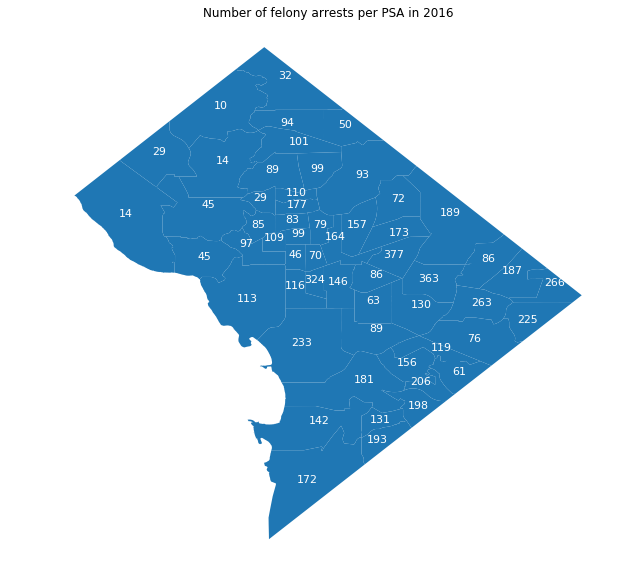

In [36]:
# Plot counts on map

arrests_by_psa.plot(figsize = (10,10))
for idx, row in arrests_by_psa.iterrows():
    plt.annotate(s=row['N'], xy=row['coords'],
                 horizontalalignment='center',
                 size=11,
                 color='white')
plt.axis('off')
plt.title('Number of felony arrests per PSA in 2016')
plt.show()

### Table 4. Characteristics of felony crime victims and people arrested on felony charges


In [37]:
# Subset victims
victims = crimes[(crimes['profile_type'] == 'People') & (crimes['person_type'] == 'VICTIM IN OFFENSE')].copy()

In [38]:
print('Total victims:', len(victims))
print('Total arrestees (unique PDIDs):', arrest_charges.pdid.nunique())

Total victims: 17582
Total arrestees (unique PDIDs): 6387


### Age

In [39]:
# Define age category function

def age_groups(series):
    if series < 18:
        return '17-under yrs'
    elif series < 25:
        return '18-24 yrs'
    elif series < 35:
        return '25-34 yrs'
    elif series < 45:
        return '35-44 yrs'
    elif series < 55:
        return '45-54 yrs'
    elif series < 65:
        return '55-64 yrs'
    elif not pd.isnull(series):
        return '65+ yrs'
    else:
        return 'Unknown'

In [40]:
# Victims age
victim_age = victims['age'].to_frame().copy()
victim_age['age'] = pd.to_numeric(victim_age['age'], errors='coerce')
victim_age['age_cat'] = victim_age['age'].apply(age_groups)
pd.crosstab(victim_age['age_cat'], columns='count')

col_0,count
age_cat,
17-under yrs,1037
18-24 yrs,2770
25-34 yrs,5081
35-44 yrs,3222
45-54 yrs,2350
55-64 yrs,1570
65+ yrs,836
Unknown,716


In [41]:
# Arrange arrestees by home psa, then arrest date; drop duplicates by pid keeping most recent arrest

'''
Note: What's below is what we actually did for the published report; however, it doesn't actually
keep the most recent arrest since we sorted first by home_psa instead of by arrest date. We're leaving this 
original approach in the code for posterity. Below, we re-do the sort with an updated approach that actually
keeps the home_psa recorded at the most recent arrest. As you'll see below, while the exact numbers change,
the difference isn't that large.
'''

# Original sort method
arrestees = arrest_charges.sort_values(['home_psa', 'mpd_arrest_date'], ascending=[False, True])\
                          .drop_duplicates('pdid', keep='last')

# New sort method (records retained in the drop are those recorded at most recent arrest)
arrestees2 = arrest_charges.sort_values(['mpd_arrest_date', 'home_psa'], ascending=[True, False])\
                          .drop_duplicates('pdid', keep='last')

In [42]:
# Arrestees age
arrestees['age'] = pd.to_numeric(arrestees['age'])
arrestees['age_cat'] = arrestees['age'].apply(age_groups)
arrestees['age_cat'].value_counts(dropna=False).sort_index()

18-24 yrs    1936
25-34 yrs    2000
35-44 yrs    1097
45-54 yrs     859
55-64 yrs     424
65+ yrs        71
Name: age_cat, dtype: int64

In [43]:
# Arrestees age (updated counting by most recent arrest)
arrestees2['age'] = pd.to_numeric(arrestees2['age'])
arrestees2['age_cat'] = arrestees2['age'].apply(age_groups)
arrestees2['age_cat'].value_counts(dropna=False).sort_index()

18-24 yrs    1937
25-34 yrs    1996
35-44 yrs    1098
45-54 yrs     861
55-64 yrs     424
65+ yrs        71
Name: age_cat, dtype: int64

###  Race

In [44]:
victims.race.value_counts(dropna=False)

Black                                        10305
White                                         5136
Unknown                                       1565
Asian                                          442
Native Hawaiian Or Other Pacific Islander       79
American Indian Or Alaska Native                55
Name: race, dtype: int64

In [45]:
# How we counted in the report
arrestees.race.value_counts(dropna=False)

Black                                        5776
White                                         471
Unknown                                       118
Asian                                          14
Native Hawaiian Or Other Pacific Islander       5
American Indian Or Alaska Native                3
Name: race, dtype: int64

In [46]:
# New counting method by most recent arrest
arrestees2.race.value_counts(dropna=False)

Black                                        5777
White                                         472
Unknown                                       116
Asian                                          14
Native Hawaiian Or Other Pacific Islander       5
American Indian Or Alaska Native                3
Name: race, dtype: int64

###  Ethncity

In [47]:
victims.ethnicity.value_counts(dropna=False)

Not Hispanic Or Latino    10070
Unknown                    5911
Hispanic Or Latino         1601
Name: ethnicity, dtype: int64

In [48]:
# Counting method in published report
arrestees.ethnicity.value_counts(dropna=False)

Not Hispanic Or Latino    3891
Unknown                   2195
Hispanic Or Latino         301
Name: ethnicity, dtype: int64

In [49]:
# Updated counting method using most recent arrest
arrestees2.ethnicity.value_counts(dropna=False)

Not Hispanic Or Latino    3892
Unknown                   2193
Hispanic Or Latino         302
Name: ethnicity, dtype: int64

### Gender

In [50]:
# Published report
arrestees.sex.value_counts(dropna=False)

Male       5249
Female     1135
Unknown       3
Name: sex, dtype: int64

In [51]:
# Updated counting method
arrestees2.sex.value_counts(dropna=False) # One PDID was counted as male and female

Male       5250
Female     1134
Unknown       3
Name: sex, dtype: int64

In [52]:
victims.sex.value_counts(dropna=False)

Male       10273
Female      7159
Unknown      150
Name: sex, dtype: int64

###  Prior Arrests

In [53]:
print(sum(arrestees.arrest_count == 0), 'arrestees had no prior arrest')
print(sum(arrestees.arrest_count == 1), 'arrestees had one prior arrest')
print(sum(arrestees.arrest_count > 1), 'arrestees had multiple prior arrest')

1068 arrestees had no prior arrest
704 arrestees had one prior arrest
4615 arrestees had multiple prior arrest


In [54]:
print(sum(arrestees2.arrest_count == 0), 'arrestees had no prior arrest')
print(sum(arrestees2.arrest_count == 1), 'arrestees had one prior arrest')
print(sum(arrestees2.arrest_count > 1), 'arrestees had multiple prior arrest')

1068 arrestees had no prior arrest
704 arrestees had one prior arrest
4615 arrestees had multiple prior arrest


### Table 5. Police district of residence of felony crime victims and arrestees

#### Victims

In [55]:
# Note that the first digit of a PSA is the relevant police district.
# O: Out of State
# U: Unknown

pd.crosstab(victims.home_psa.apply(lambda x: x.strip()[0]), columns='count')

col_0,count
home_psa,
1,1326
2,956
3,1460
4,1832
5,2023
6,2444
7,2086
O,3888
U,1567


In [56]:
print('Total:', len(victims))

Total: 17582


#### Arrestees

In [57]:
# How we did it in the published report
pd.crosstab(arrestees.home_psa.apply(lambda x: x.strip()[0]), columns='count')

col_0,count
home_psa,
1,503
2,86
3,388
4,565
5,933
6,1222
7,1338
O,809
U,543


In [58]:
print('Total:', len(arrestees))

Total: 6387


In [59]:
# New way
pd.crosstab(arrestees2.home_psa.apply(lambda x: x.strip()[0]), columns='count')

col_0,count
home_psa,
1,492
2,85
3,384
4,557
5,912
6,1213
7,1355
O,814
U,575


In [60]:
print('Total:', len(arrestees2))

Total: 6387


### Figure 4. PSA of residence of victims of and people arrested for felony crimes in 2016.

#### Panel A. Number of victims per psa

In [61]:
pd.crosstab(victims['home_psa'], columns='count')

col_0,count
home_psa,
101,42
102,97
103,150
104,252
105,197
106,167
107,197
108,224
201,135


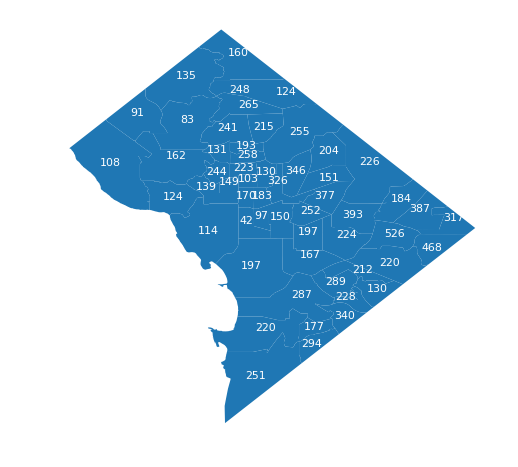

In [62]:
def annotated_geoplot(df, figsize=(8, 8), colname='N'):
    df = df.copy()
    df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:][0])
    df.plot(figsize=figsize)
    for idx, row in df.iterrows():
        plt.annotate(s=row[colname], xy=row['coords'],
                     horizontalalignment='center',
                     size=11,
                     color='white')
    plt.axis('off')

# Panel A. Number of victims per PSA

# Count of victims by PSA
victims_by_psa = victims.groupby('home_psa').size().reset_index(name='N')

# Change unknowns and out of state to nulls, make PSA numeric
victims_by_psa['home_psa'] = pd.to_numeric(victims_by_psa['home_psa'], errors='coerce')

# Merge with psa data frame
geo_victims_by_psa = pd.merge(psa_raw, victims_by_psa, left_on='PSA', right_on='home_psa')

annotated_geoplot(geo_victims_by_psa)

#### Panel B. Number of arrestees per psa (Map from Paul)

In [63]:
pd.crosstab(arrestees['home_psa'], columns='count')

col_0,count
home_psa,
101,42
102,32
103,131
104,65
105,93
106,44
107,14
108,82
201,7


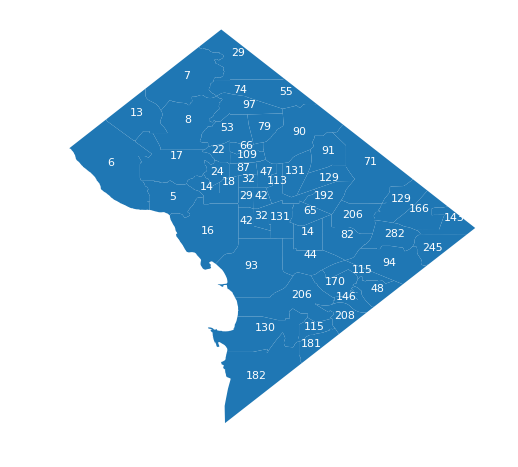

In [64]:
# Create dataframe of arrestees by psa
arrestees_by_psa = arrestees.groupby('home_psa').size().reset_index(name='N')

# Remove unknowns, make PSA numeric
arrestees_by_psa['home_psa'] = pd.to_numeric(arrestees_by_psa['home_psa'], errors='coerce')

# Merge with psa data frame
geo_arrestees_by_psa = pd.merge(psa_raw, arrestees_by_psa, left_on='PSA', right_on='home_psa')

annotated_geoplot(geo_arrestees_by_psa)

### Table 6. Number of people served by DBH in 2015 or 2016 and who were also arrested on felony charges in 2016. 

In [65]:
# Get unique individuals in each data source and select person-invariant columns

kept_cols = ['age', 'arrest_count', 'consumer_id', 'ethnicity', 'race', 'sex']

mh_people = mh[kept_cols].drop_duplicates(['consumer_id', 'sex'])
seh_people = seh[kept_cols].drop_duplicates(['consumer_id', 'sex'])
sud_people = sud[kept_cols].drop_duplicates(['consumer_id', 'sex'])

'''
We only drop duplicates on consumer_id and sex (and don't sort on other columns) 
because we age will naturally vary within consumer_id (i.e. they get older over multiple visits)
and ethnicity/race will vary too because its recorded differently (but we don't care about this here).
Arrest count may naturally vary too, but we also don't care about this right now.
'''

mh_people.name = 'People who received mental health services'
seh_people.name = 'People who had an intake at Saint Elizabeths'
sud_people.name = 'People who received substance use disorder services'

for df in mh_people, seh_people, sud_people:
    print('{}: {}'.format(df.name, len(df)))
    print()
    
print('Total number of people served:', len(mh_people) + len(seh_people) + len(sud_people))

People who received mental health services: 1382

People who had an intake at Saint Elizabeths: 165

People who received substance use disorder services: 560

Total number of people served: 2107


In [66]:
# Stack these dfs together and count unique consumer_ids

num_unique_people = pd.concat([mh_people, seh_people, sud_people])['consumer_id'].nunique()

print('Unique people served across the three DBH service lines (2016):', num_unique_people)
print('Fraction of unique people arrested for felony crimes who also received services from DBH:',
      num_unique_people/arrest_charges.pdid.nunique())

Unique people served across the three DBH service lines (2016): 1625
Fraction of unique people arrested for felony crimes who also received services from DBH: 0.2544230468138406


### Figure 5. MPD crisis intervention incidents per week in 2016.

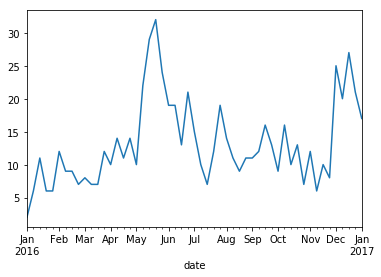

In [67]:
cio.groupby(pd.Grouper(key='date', freq='W')).size().plot(label='MPD crisis intervention incidents')

### Table 7. Felony and misdemeanor charges filed in DC Superior Court in 2016.

In [68]:
'''
This code creates the table frequencies used to generate the percentages in Table 7. The cell suppression policy of 
our data use agreement with the Superior Court stipulates that we do not display cells with values less than 20,
so here we create the frequency table then replace values that are less than 20 with a string.
'''

disposition_crosstab = pd.crosstab(case_charges.dmpsj_category, case_charges.disposition_category, margins=True)
disposition_crosstab.sort_values(by='All', ascending=False, inplace=True)
disposition_crosstab = disposition_crosstab.applymap(lambda x: x if x >=20 else '<20')

In [69]:
disposition_crosstab

disposition_category,deferred,dismissed,diverted,guilty,not_guilty,open,All
dmpsj_category,,,,,,,
All,804,10558,1774,6483,466,4085,24170
Assault,339,1972,507,1112,157,663,4750
Drugs,98,1801,183,1195,36,664,3977
Weapons,24,1830,53,779,112,1059,3857
Theft,105,891,379,807,<20,277,2476
Unlawful entry,33,822,185,376,23,146,1585
Failure to appear,<20,775,<20,372,<20,111,1284
Property,57,380,139,244,<20,130,962
Assault on a police officer,65,317,95,220,33,73,803


### Table 8. How convictions are reached.

In [70]:
# how are convictions reached in court?
pd.crosstab(case_charges.nuanced_disposition, case_charges.is_guilty)

is_guilty,False,True
nuanced_disposition,,
guilty by 904 plea,0,29
guilty by court trial,0,467
guilty by jury trial,0,227
guilty by plea,0,5760
guilty by plea but deferred,804,0
not guilty by acquittal,77,0
not guilty by court trial,201,0
not guilty by jury trial,188,0


### Figure 7. Distribution of sentences to be served in months by offense type (2016)

In [71]:
# Subset sentencing data to 2016
sent = sent[sent['Sentence_Year'] == 2016]

# Remove Other cases
sent = sent[sent['Offense_Type'] != 'Other']

# Summarize data
sent.groupby('Offense_Type').agg({'Sentence_to_Serve_Months': 'describe'})

Sentence_to_Serve_Months
Offense_Type                                
Drug         count                441.000000
             mean                   4.920635
             std                    9.414957
             min                    0.000000
             25%                    0.000000
             50%                    0.000000
             75%                    6.000000
             max                   66.000000
Homicide     count                 40.000000
             mean                 162.525000
             std                   91.691229
             min                    1.000000
             25%                   91.500000
             50%                  138.000000
             75%                  240.000000
             max                  420.000000
Property     count                299.000000
             mean                  18.655518
             std                   25.983056
             min                    0.000000
             25%                    1.000000
             50%                   12.000000
             75%                   24.000000
             max                  180.000000
Sex          count                 69.000000
             mean                  78.275362
             std                   95.830562
             min                    0.000000
             25%                   14.000000
             50%                   40.000000
             75%                  108.000000
             max                  444.000000
Violent      count                659.000000
             mean                  30.018209
             std                   35.885113
             min                    0.000000
             25%                    3.000000
             50%                   22.000000
             75%                   48.000000
             max                  192.000000
Weapon       count                407.000000
             mean                  21.248157
             std                   23.444407
             min                    0.000000
             25%                    1.000000
             50%                   14.000000
             75%                   34.000000
             max                  108.000000

### Figure 8

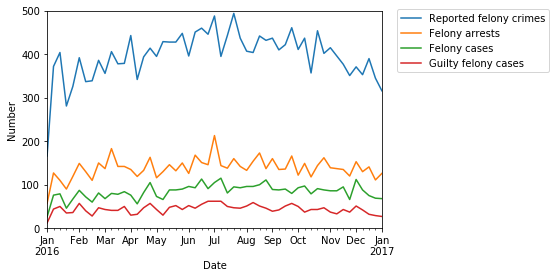

In [72]:
# Number of felony crime incidents, arrests, cases, and guilty cases (felonies)

frequency = 'W'

crime_incidents = crimes\
                        .sort_values(by='offense_report_date', ascending=True)\
                        .drop_duplicates('ccn', keep='last')\
                        .groupby(pd.Grouper(key='offense_report_date', freq=frequency)).size()
crime_incidents.plot(label='Reported felony crimes')

arrests = arrest_charges\
                        .sort_values(by='mpd_arrest_date', ascending=True)\
                        .drop_duplicates('mpd_arrest_number', keep='last')\
                        .groupby(pd.Grouper(key='mpd_arrest_date', freq=frequency)).size()
arrests.plot(label='Felony arrests')

felony_cases = case_charges[case_charges.is_felony]
felony_cases_freq = felony_cases.groupby('case_no')\
                                   .file_date.min()\
                                   .reset_index()\
                                   .groupby(pd.Grouper(key='file_date', freq=frequency)).size()
felony_cases_freq.plot(label='Felony cases')

guilty_felony_cases = felony_cases[felony_cases.is_guilty]
guilty_felony_cases_freq = guilty_felony_cases.groupby('case_no')\
                                              .file_date.min()\
                                              .reset_index()\
                                              .groupby(pd.Grouper(key='file_date', freq=frequency)).size()
guilty_felony_cases_freq.plot(label='Guilty felony cases')

plt.xlabel('Date')
plt.ylabel('Number')
plt.ylim([0, 500])
plt.legend(bbox_to_anchor=(1.03, 1.03));

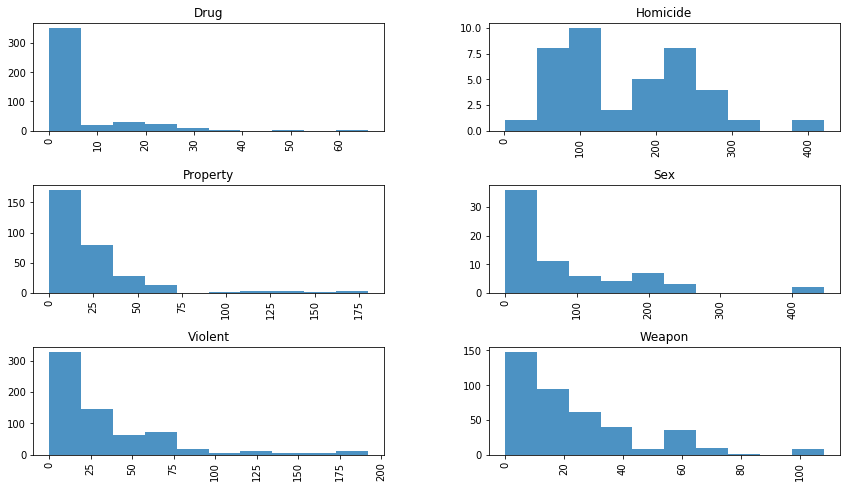

In [73]:
# Histograms of sentence length by offense category

sent.Sentence_to_Serve_Months.hist(by=sent['Offense_Type'], figsize=(14, 8), alpha=0.8);